In [42]:
import os
import requests
import pandas as pd
import geopandas as gpd
import sys
import datetime
import frictionless
sys.path.append("../morpc-common/")
import morpc

In [2]:
OUTPUT_DIR = './output_data'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [3]:
data_raw, resource, schema = morpc.frictionless_load_data('../morpc-renewenergyfacilities-standardize/output_data/renewable_portfolio_standard_facilities.resource.yaml')

morpc.load_frictionless_data | INFO | Loading Frictionless Resource file at location ..\morpc-renewenergyfacilities-standardize\output_data\renewable_portfolio_standard_facilities.resource.yaml
morpc.load_frictionless_data | INFO | Loading data, resource file, and schema from their source locations
morpc.load_frictionless_data | INFO | --> Data file: ..\morpc-renewenergyfacilities-standardize\output_data\renewable_portfolio_standard_facilities.csv
morpc.load_frictionless_data | INFO | --> Resource file: ..\morpc-renewenergyfacilities-standardize\output_data\renewable_portfolio_standard_facilities.resource.yaml
morpc.load_frictionless_data | INFO | --> Schema file: ..\morpc-renewenergyfacilities-standardize\output_data\renewable_portfolio_standard_facilities.schema.yaml
morpc.load_frictionless_data | INFO | Loading data.
frictionless_cast_field_types | INFO | Casting field Name Of Renewable Generating Facility as type string.
frictionless_cast_field_types | INFO | Casting field State as

In [4]:
data = data_raw.copy()
data['County'] = [x.replace(' County', '')for x in data['County']]
data['Year'] = [int(x.strftime('%Y')) for x in data['Approved']]

In [5]:
county_names = morpc.countyLookup(scope = "REGION15").list_names()

Loading data for MORPC 15-County region only


In [6]:
data = data.loc[data['County'].isin(county_names)]

<Axes: >

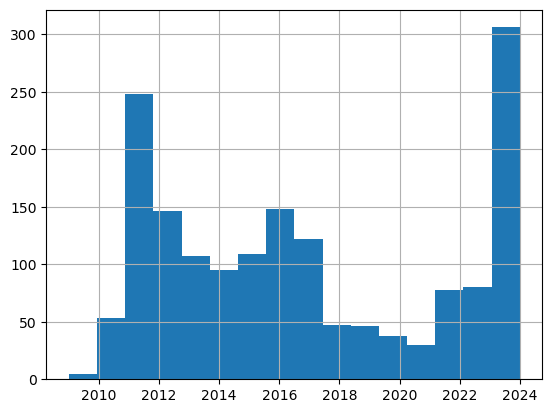

In [7]:
data['Year'].hist(bins=len(data['Year'].unique()))

In [8]:
def calc_counts_sums(data, index_col, year_col, type_col, sum_col):
    print(f"INFO | Calculating sums for {sum_col} and counts for {type_col}")
    data = data.copy()
    data['count'] = 1
    count_col = 'count'
    data['total'] = data[sum_col]
    data = data[[index_col, year_col, type_col, 'count', 'total']].groupby([index_col, year_col, type_col]).sum().reset_index()
    data = data.set_index([index_col, year_col])
    data = data.pivot(columns = [type_col]).fillna(0)
    data.columns = data.columns.map("_".join)
    columns = data.columns # Store columns to add zero observations later
    data = data.reset_index()
    return(data, columns)

def add_zeros_for_non_obs(data, index_col, year_col, columns):
    print("INFO | Adding zeros to empty observations.")
    # Add observations that have zeros so all combinations of index and year have a observation for all types.
    accounted_place = data[index_col].unique()	
    first_year = data[year_col].min()
    last_year = pd.Series([x for x in data[year_col] if x < 9999]).max()

    data_zeros = data.copy()
    for year in range(int(first_year), int(last_year)+1, 1):  # range stops at one less than the second parameter, hence the +1
        for place in accounted_place:
            if data_zeros[(data_zeros[year_col] == year) & (data_zeros[index_col] == place)].shape[0] == 0:
                entry = {
                    year_col: year,
                    index_col: place,
                }
                for c in columns:
                    entry[c] = 0
                
                data_zeros = pd.concat([data_zeros, pd.DataFrame.from_dict(entry, orient='index').transpose()], ignore_index=True)
    return (data_zeros)

def pivot_wide_to_long(data, index_col, preserve_cols, year_col, type_col):
    print("INFO | Pivoting to long format")
    data = data.melt(id_vars=list(pd.core.common.flatten([index_col, preserve_cols, year_col]))).rename(columns={'variable':type_col})
    data = data.sort_values([index_col, type_col, year_col])
    return(data)

In [9]:
data, columns = calc_counts_sums(data, 'County', 'Year', 'Technology', 'Capacity (MW)')

INFO | Calculating sums for Capacity (MW) and counts for Technology


In [10]:
wide = add_zeros_for_non_obs(data, 'County', 'Year', columns).sort_values(['County', 'Year'])

INFO | Adding zeros to empty observations.


In [11]:
wide['COUNTYFP'] = wide['County'].map(morpc.CONST_COUNTY_NAME_TO_ID)

In [12]:
long = pivot_wide_to_long(wide, 'County', 'COUNTYFP', 'Year', 'Technology')

INFO | Pivoting to long format


In [13]:
wide.to_csv(f'{OUTPUT_DIR}/morpc-rps-county-wide.csv', index=False)
long.to_csv(f'{OUTPUT_DIR}/morpc-rps-county-long.csv', index=False)  

In [14]:
region_wide = wide.drop(columns = ['County', 'COUNTYFP']).groupby(['Year']).sum().reset_index()

In [15]:
region_wide['Name'] = '15-County Region'
region_wide['GEOID'] = '001'

In [16]:
region_long = pivot_wide_to_long(region_wide, 'Name', 'GEOID', 'Year', 'Technology')

INFO | Pivoting to long format


In [17]:
region_wide.to_csv(os.path.join(OUTPUT_DIR, 'morpc-rps-region-wide.csv'), index=False)
region_long.to_csv(os.path.join(OUTPUT_DIR, 'morpc-rps-region-long.csv'), index=False)

In [23]:
geo_lookup = pd.read_csv('../morpc-geos-collect/output_data/morpc-geos-lookup.csv')
county_fq_map = geo_lookup.loc[geo_lookup['SUMLEVEL'] == '050'][['GEOID', 'GEOIDFQ']].set_index('GEOID').to_dict()

In [27]:
long['GEOIDFQ'] = [county_fq_map['GEOIDFQ'][int(x)] for x in long['COUNTYFP']]
long['SUMLEVEL'] = '050'
long['METRIC'] = ['Facilities' if x.startswith('count_') else 'Capacity' for x in long['Technology']]
long['FUEL_TYPE'] = [x.split("_")[-1] for x in long['Technology']]
long['VALUE'] =  [float(x) for x in long['value']]
long = long.rename(columns = {'County':'NAME', 'Year':'YEAR'})
long = long[['NAME', 'GEOIDFQ', 'SUMLEVEL', 'YEAR', 'METRIC', 'FUEL_TYPE', 'VALUE']]

In [28]:
long

,NAME,GEOIDFQ,SUMLEVEL,YEAR,METRIC,FUEL_TYPE,VALUE
0,Delaware,0500000US39041,050,2009,Facilities,Biomass,0.0
1,Delaware,0500000US39041,050,2010,Facilities,Biomass,0.0
2,Delaware,0500000US39041,050,2011,Facilities,Biomass,0.0
3,Delaware,0500000US39041,050,2012,Facilities,Biomass,0.0
4,Delaware,0500000US39041,050,2013,Facilities,Biomass,0.0
...,...,...,...,...,...,...,...
2875,Union,0500000US39159,050,2020,Capacity,Wind,0.0
2876,Union,0500000US39159,050,2021,Capacity,Wind,0.0
2877,Union,0500000US39159,050,2022,Capacity,Wind,0.0
2878,Union,0500000US39159,050,2023,Capacity,Wind,0.0


In [36]:
region_long = long.drop(columns=['NAME', 'GEOIDFQ', 'SUMLEVEL']).groupby(['YEAR', 'METRIC', 'FUEL_TYPE']).sum().reset_index()

In [37]:
region_long['NAME'] = '15-County Region'
region_long['GEOIDFQ'] = '001'
region_long['SUMLEVEL'] = 'M01'

In [39]:
all_long = pd.concat([long, region_long])

In [40]:
all_long.to_csv('./output_data/morpc-renewenergyfacilities-rps-long.csv', index=False)

In [43]:
frictionless.Schema.describe('./output_data/morpc-renewenergyfacilities-rps-long.csv').to_yaml('./output_data/morpc-renewenergyfacilities-rps-long.schema.yaml')

'fields:\n  - name: NAME\n    type: string\n  - name: GEOIDFQ\n    type: string\n  - name: SUMLEVEL\n    type: integer\n  - name: YEAR\n    type: integer\n  - name: METRIC\n    type: string\n  - name: FUEL_TYPE\n    type: string\n  - name: VALUE\n    type: number\n'

In [44]:
description="""\
           A long for table containing renewable energy facilities that were approved by PUCO. See 
           https://puco.ohio.gov/utilities/electricity/resources/ohio-renewable-energy-portfolio-standard/renewable-energy-resource-generating-facility-certification
           Data pulled 2025-02-13 from https://puco.my.salesforce.com/sfc/p/#t0000000GzXt/a/t0000000cV7M/GSiEQauuUkO6XhIJlxy6yIvkx9_lA3oXaYfvGpEGkcU
           """
morpc.frictionless_create_resource('morpc-renewenergyfacilities-rps-long.csv', 
                                   resourcePath='./output_data/morpc-renewenergyfacilities-rps-long.resource.yaml',
                                   schemaPath='morpc-renewenergyfacilities-rps-long.schema.yaml',
                                   description= " ".join(line.strip() for line in description.splitlines()),
                                   computeBytes=True,
                                   computeHash=True,
                                   writeResource=True
                                  )

morpc.frictionless_create_resource | INFO | Format not specified. Using format derived from data file extension: csv
morpc.frictionless_create_resource | INFO | Title not specified. Using placeholder value derived from data filename: morpc-renewenergyfacilities-rps-long
morpc.frictionless_create_resource | INFO | Name not specified. Using placeholder value derived from data filename: morpc-renewenergyfacilities-rps-long
morpc.frictionless_create_resource | WARNING | Resource type not specified. Using default type 'file'
morpc.frictionless_create_resource | INFO | Writing Frictionless Resource file to output_data\morpc-renewenergyfacilities-rps-long.resource.yaml


{'name': 'morpc-renewenergyfacilities-rps-long',
 'type': 'file',
 'title': 'morpc-renewenergyfacilities-rps-long',
 'description': 'A long for table containing renewable energy facilities that '
                'were approved by PUCO. See '
                'https://puco.ohio.gov/utilities/electricity/resources/ohio-renewable-energy-portfolio-standard/renewable-energy-resource-generating-facility-certification '
                'Data pulled 2025-02-13 from '
                'https://puco.my.salesforce.com/sfc/p/#t0000000GzXt/a/t0000000cV7M/GSiEQauuUkO6XhIJlxy6yIvkx9_lA3oXaYfvGpEGkcU ',
 'profile': 'data-resource',
 'path': 'morpc-renewenergyfacilities-rps-long.csv',
 'scheme': 'file',
 'format': 'csv',
 'mediatype': 'text/csv',
 'hash': '78bb027fd89cf71080f172070e5dafa4',
 'bytes': 199904,
 'schema': 'morpc-renewenergyfacilities-rps-long.schema.yaml'}